SOURCE: https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [ ]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

import datetime 

# 0. Load and convert to parquet 

In [ ]:
schema = {
    'InvoiceNo': np.str, 
    'StockCode': np.str,
    'Description': np.str, 
    'Quantity': np.int64, 
    'InvoiceDate': np.datetime64,
    'UnitPrice': np.float64, 
    'CustomerID': np.float64, 
    'Country': np.str
}

In [ ]:
sales = pd.read_excel('datasets/online-retail.xlsx', dtype=schema)
sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
sales['Country'] = sales['Country'].astype('category')

sales.dtypes

sales.head()

In [ ]:
def get_month(dt):
    return datetime.date(dt.year, dt.month, 1)
    
    
sales['ptn_date'] = sales['InvoiceDate'].apply(lambda x: get_month(x))


In [ ]:
sales.to_parquet('datasets/online_retail.parquet.gzip', compression='gzip')
                 #, partition_cols=['ptn_date'])

# 1. Load and prepare data

In [ ]:
sales = pd.read_parquet('datasets/online_retail.parquet.gzip')

In [ ]:
sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country              category
ptn_date               object
dtype: object

In [ ]:
sales.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
ptn_date            0
dtype: int64

## Replace all rows with empty CustomerID

In [ ]:
sales.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
sales['Price'] = sales['Quantity'] * sales['UnitPrice']

In [ ]:
sales['InvoiceNo'].value_counts().head()

576339    542
579196    533
580727    529
578270    442
573576    435
Name: InvoiceNo, dtype: int64

## Aggregate all rows for orders

In [ ]:
orders = sales.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'Price': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [ ]:
NOW = orders['InvoiceDate'].max() + timedelta(days=1)

period = 365

print(NOW)

2011-12-10 12:50:00


# Calculate the Recency, Frequency and Monetary Value of each customers

In [ ]:
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [ ]:
orders.sample(20)

,InvoiceNo,InvoiceDate,CustomerID,Price,DaysSinceOrder
15030,573381,2011-10-30 14:05:00,17590.0,349.38,40
17223,578352,2011-11-24 10:02:00,16596.0,129.50,16
7510,555405,2011-06-02 19:17:00,17531.0,296.70,190
13720,570270,2011-10-10 10:23:00,15304.0,111.90,61
5661,550919,2011-04-21 14:06:00,14735.0,19.50,232
20507,C559140,2011-07-06 13:42:00,13420.0,-17.40,156
3803,546249,2011-03-10 13:58:00,14606.0,99.95,274
20072,C554334,2011-05-23 17:16:00,13089.0,-17.85,200
8130,556912,2011-06-15 13:26:00,15005.0,289.86,177
20443,C558360,2011-06-28 15:10:00,16701.0,-13.46,164


In [ ]:
sales[sales['InvoiceNo']=='C558360'] #C558360, C544590

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ptn_date,Price
242590,C558360,21530,DAIRY MAID TOASTRACK,-12,2011-06-28 15:10:00,0.79,16701.0,United Kingdom,2011-06-01,-9.48
242591,C558360,79163,BLACK CHAMPAGNE GLASS,-7,2011-06-28 15:10:00,0.39,16701.0,United Kingdom,2011-06-01,-2.73
242592,C558360,23168,CLASSIC CAFE SUGAR DISPENSER,-1,2011-06-28 15:10:00,1.25,16701.0,United Kingdom,2011-06-01,-1.25


In [ ]:

aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)

rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head()



,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006}}

In [ ]:

def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 
    

rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))


In [ ]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,6,3598.21,5,4,5,545
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [ ]:

segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,hibernating
1,12347.0,2,6,3598.21,5,4,5,545,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


# Visualize our customers segments

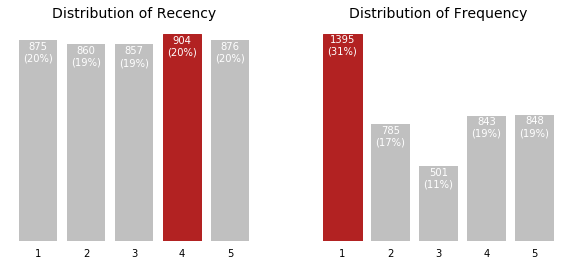

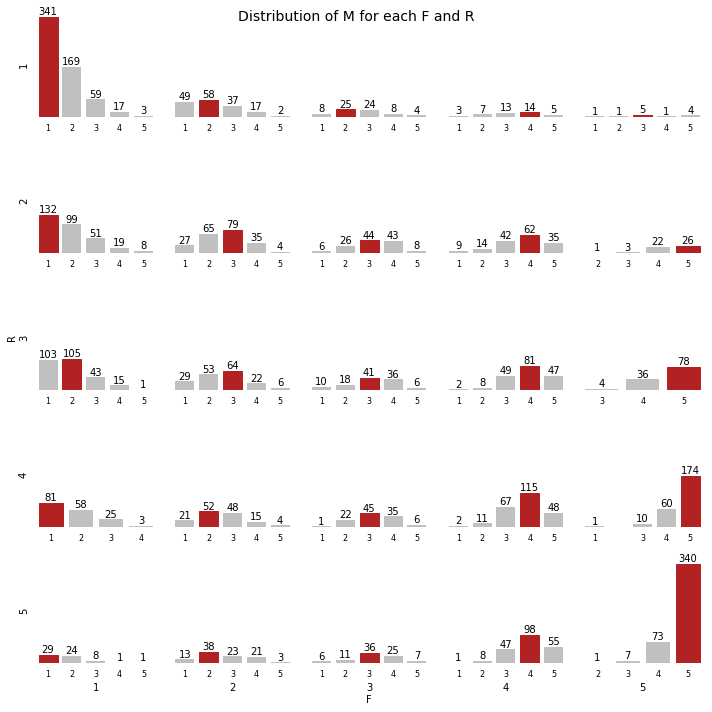

In [ ]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

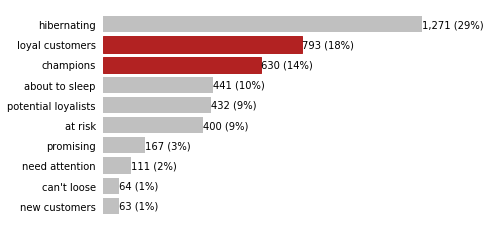

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()